<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1: Denise La Gordt Dillie
# Student 2: Andreea Maican
# Student 3: Sambhav Jain

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [4]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [ ]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]


train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

In [ ]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [ ]:
def loss_batch(model, loss_func, xb, yb, optimizer=None):
    yb = torch.argmax(yb, dim=1)

    assert yb.dim() <= 1, "Target tensor must have 0 or 1 dimensions"
    assert yb.numel() == len(xb), "Target tensor size must match input size"

    output = model(xb)
    loss = loss_func(output, yb.long())

    if optimizer is not None:
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    _, preds = torch.max(output, 1)
    corrects = torch.sum(preds == yb.long())

    return loss.item(), corrects, len(xb)

In [ ]:
import matplotlib.pyplot as plt

def fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    test_losses = []
    test_accs = []

    for epoch in tqdm(range(epochs)):
        # Training process
        model.train()
        running_loss = 0.0
        running_corrects = 0
        sample_num = 0

        for xb, yb in train_dl:
            losses, corrects, nums = loss_batch(model, loss_func, xb, yb, optimizer)
            running_loss += losses * xb.size(0)
            running_corrects += corrects
            sample_num += nums

        train_loss = running_loss / sample_num
        train_acc = running_corrects.double() / sample_num

        # Validation process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in valid_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            val_loss = running_loss / sample_num
            val_acc = running_corrects.double() / sample_num

        # Testing process
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            running_corrects = 0
            sample_num = 0

            for xb, yb in test_dl:
                losses, corrects, nums = loss_batch(model, loss_func, xb, yb)
                running_loss += losses * xb.size(0)
                running_corrects += corrects
                sample_num += nums

            test_loss = running_loss / sample_num
            test_acc = running_corrects.double() / sample_num

        # Print the results
        print(f'EPOCH: {epoch+1:0>{len(str(epochs))}}/{epochs}', end=' ')
        print(f'LOSS: {train_loss:.4f}', f'ACC: {train_acc:.4f} ', end=' ')
        print(f'VAL-LOSS: {val_loss:.4f}', f'VAL-ACC: {val_acc:.4f} ', end=' ')
        print(f'TEST-LOSS: {test_loss:.4f}', f'TEST-ACC: {test_acc:.4f} ', end='\n')

        # Save losses and accuracies
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    # Plot losses and accuracies
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, epochs+1), train_losses, 'r:', label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, 'g:', label='Validation Loss')
    plt.plot(range(1, epochs+1), test_losses, 'b:', label='Test Loss')
    plt.plot(range(1, epochs+1), train_accs, 'r', label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accs, 'g', label='Validation Accuracy')
    plt.plot(range(1, epochs+1), test_accs, 'b', label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss / Accuracy')
    plt.title('Loss and Accuracy vs. Epochs')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def get_data(train_ds, valid_ds, batch_size):
    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(valid_ds, batch_size=batch_size * 2),
    )

In [ ]:
batch_size = 64
train_dl, valid_dl = get_data(train_dataset, val_dataset, batch_size)
test_dl = DataLoader(test_dataset, batch_size=batch_size * 2)

In [ ]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

In [ ]:
model = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

In [ ]:
from torch import optim

lr = 0.06
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
epochs = 20
loss_func = F.cross_entropy

fit(epochs, model, loss_func, optimizer, train_dl, valid_dl, test_dl)

## Task 1: Question 5d

### Experiment 1
In this experiment, we change the number of convolutional filters in the model architecture. Convolutional filters are responsible for capturing different patterns and features from the input data. By altering the number of filters, we can assess the effect on the model's performance.

In [ ]:
# Experiment 1: Change the Number of Convolutional Filters
model_exp1 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 16, kernel_size=4, stride=4, rotation=4, reflection=False), # Change the number of filters to 16
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(16), # Adjust the batch normalization layer accordingly
    nn.Dropout(0.2),
    nn.Conv2d(16, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp1 = optim.SGD(model_exp1.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp1, loss_func, optimizer_exp1, train_dl, valid_dl, test_dl)

### Experiment 2
In this experiment, we change the activation function used in the model architecture. The activation function introduces non-linearity to the model, allowing it to learn complex patterns and make non-linear predictions. By altering the activation function, we can assess its effect on the model's performance.

In [ ]:
# Experiment 2: Change Activation Function
model_exp2 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.LeakyReLU(inplace=True),  # Change activation function
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.LeakyReLU(inplace=True),  # Change activation function
    nn.Linear(100, 3),
)

optimizer_exp2 = optim.SGD(model_exp2.parameters(), lr=lr, momentum=0.9)

fit(epochs, model_exp2, loss_func, optimizer_exp2, train_dl, valid_dl, test_dl)

### Experiment 3
In this experiment, we change the learning rate used for training the model. The learning rate determines the step size at which the model updates its parameters during the optimization process. By adjusting the learning rate, we can explore its effect on the convergence speed and the overall performance of the model.

In [ ]:
# Experiment 3: Adjust Learning Rate
lr_exp3 = 0.01  # Change learning rate

model_exp3 = nn.Sequential(
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(1, 32, kernel_size=4, stride=4, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(32),
    nn.Dropout(0.2),
    nn.Conv2d(32, 64, kernel_size=3, stride=3),
    nn.ReLU(inplace=True),
    sc.Slice(rotation=4, reflection=False),
    sc.SymmetryConv2d(64, 10, kernel_size=5, stride=1, rotation=4, reflection=False),
    nn.ReLU(inplace=True),
    sc.SymmetryPool(),
    nn.BatchNorm2d(10),
    nn.Dropout(0.2),
    Lambda(lambda x: x.view(x.size(0), -1)),
    nn.Linear(40, 100),
    nn.ReLU(inplace=True),
    nn.Linear(100, 3),
)

optimizer_exp3 = optim.SGD(model_exp3.parameters(), lr=lr_exp3, momentum=0.9)

fit(epochs, model_exp3, loss_func, optimizer_exp3, train_dl, valid_dl, test_dl)

# Task 2: Carpet Matching 

In [5]:
# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

Carpet train shape: (15000, 1, 96, 60)
Label train shape: (15000,)
Ground truth test shape: (300,)
Query carpets shape: (300, 1, 96, 60)
Candidate carpets shape: (300, 4, 1, 96, 60)


In [15]:
from sklearn.metrics import pairwise_distances
import torch
import torch.nn as nn
import torch.optim as optim

def query_performance(queries, targets, gt, top=1):
    assert top >= 1
    cnt = 0

    queries_np = queries.cpu().numpy()
    targets_np = targets.cpu().numpy()

    for i in range(gt.shape[0]):
        q = torch.from_numpy(queries_np[i][None]).float().to(device)
        t = torch.from_numpy(targets_np[i]).float().to(device)

        with torch.no_grad():
            emb_q = model.forward_once(q).cpu().numpy()  # Use forward_once method to get the embeddings
            emb_t = model.forward_once(t).cpu().numpy()  # Use forward_once method to get the embeddings

            dists = pairwise_distances(emb_q, emb_t)

            if top == 1:
                pred = np.argmin(dists)
                if pred == gt[i]:
                    cnt += 1
            else:
                pred = np.argsort(dists)
                if gt[i] in pred[0, :top].tolist():
                    cnt += 1

    return 100 * cnt / gt.shape[0]


In [13]:
# class CarpetMatchingModel(nn.Module):
#     def __init__(self, num_classes):
#         super(CarpetMatchingModel, self).__init__()
#         # Define your model architecture here
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
#         self.relu1 = nn.ReLU()
#         self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
#         self.relu2 = nn.ReLU()
#         self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
#         self.relu3 = nn.ReLU()
#         self.avgpool = nn.AvgPool2d(4)
#         self.flatten = nn.Flatten()
#         self.linear = nn.Linear(60, num_classes)
#
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu1(x)
#         x = self.conv2(x)
#         x = self.relu2(x)
#         x = self.conv3(x)
#         x = self.relu3(x)
#         x = self.avgpool(x)
#         x = self.flatten(x)
#         x = self.linear(x)
#         return x
#
class CarpetMatchingModel(nn.Module):
    def __init__(self, num_classes):
        super(CarpetMatchingModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(23040, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward_once(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return torch.abs(output1 - output2)

In [8]:
model = CarpetMatchingModel(num_classes=200)
loss_func = F.cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the numpy arrays to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).long()
queries_tensor = torch.from_numpy(queries).float()
targets_tensor = torch.from_numpy(targets).float()

# Set the device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)
queries_tensor = queries_tensor.to(device)
targets_tensor = targets_tensor.to(device)

EPOCH: 01/10 LOSS: 4.0649 ACC: 0.2484 
EPOCH: 02/10 LOSS: 0.7961 ACC: 0.8540 
EPOCH: 03/10 LOSS: 0.0891 ACC: 0.9876 
EPOCH: 04/10 LOSS: 0.0057 ACC: 1.0000 
EPOCH: 05/10 LOSS: 0.0021 ACC: 1.0000 
EPOCH: 06/10 LOSS: 0.0016 ACC: 1.0000 
EPOCH: 07/10 LOSS: 0.0012 ACC: 1.0000 
EPOCH: 08/10 LOSS: 0.0010 ACC: 1.0000 
EPOCH: 09/10 LOSS: 0.0008 ACC: 1.0000 
EPOCH: 10/10 LOSS: 0.0006 ACC: 1.0000 


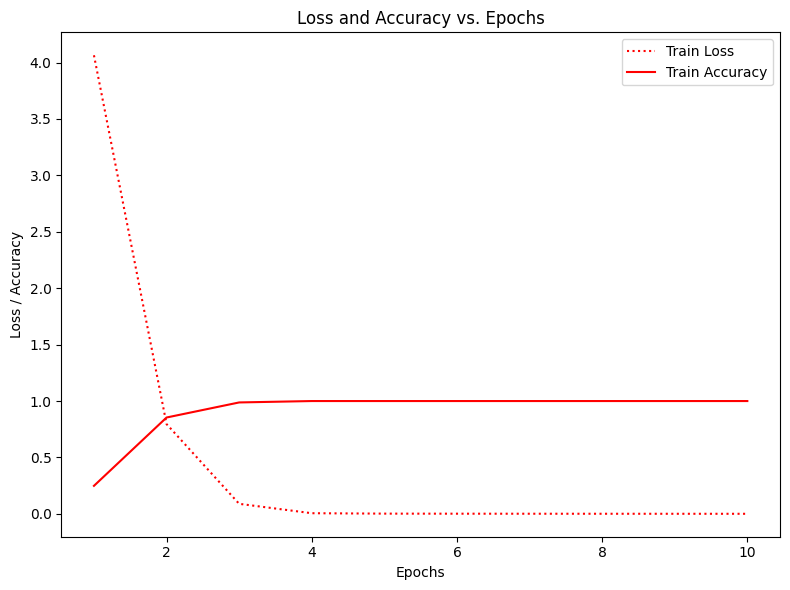

CarpetMatchingModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=23040, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=200, bias=True)
)

In [10]:
num_epochs = 10

# Define the batch size
batch_size = 64

# Adjust batch size to be divisible by 2
batch_size = batch_size if batch_size % 2 == 0 else batch_size - 1

train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Mini-batch training
    for i in range(0, X_tensor.size(0), batch_size):
        inputs1 = X_tensor[i:i+batch_size:2]     # Select even indices for inputs1
        inputs2 = X_tensor[i+1:i+batch_size+1:2]  # Select odd indices for inputs2

        labels = y_tensor[i:i+batch_size:2]       # Select labels for inputs1

        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs1, inputs2)  # Pass different inputs to the model
        loss = loss_func(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Store the average loss and accuracy for the epoch
    train_loss = running_loss / (X_tensor.size(0) / batch_size)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Print the average loss and accuracy for the epoch
    print(f'EPOCH: {epoch+1:0>{len(str(num_epochs))}}/{num_epochs}', end=' ')
    print(f'LOSS: {train_loss:.4f}', f'ACC: {train_accuracy:.4f} ', end='\n')

# Plot losses and accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, 'r:', label='Train Loss')
plt.plot(range(1, num_epochs+1), train_accuracies, 'r', label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.title('Loss and Accuracy vs. Epochs')
plt.legend()
plt.tight_layout()
plt.show()

model.eval()

In [16]:
top_1_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=1)
print(f'top-1 accuracy: {top_1_accuracy:.2f}%')
top_2_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=2)
print(f'top-2 accuracy: {top_2_accuracy:.2f}%')
top_3_accuracy = query_performance(queries_tensor, targets_tensor, gt, top=3)
print(f'top-3 accuracy: {top_3_accuracy:.2f}%')

top-1 accuracy: 58.33%
top-2 accuracy: 88.00%
top-3 accuracy: 96.67%
